In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import main
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.neighbors import DistanceMetric
from pandas.plotting import lag_plot
from sklearn.cluster import DBSCAN
from scipy.integrate import odeint

### Data Preprocessing

Data from https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data/resource/260bbbde-2316-40eb-aec3-7cd7bfc2f590

In [5]:
data = main.getdata('data/timeseries25May.csv')

In [6]:
data = data.loc[data['country'].isin(['Netherlands', 'Belgium', 'Italy', 'Sweden', 'Denmark', 'Norway', 'Spain', 'United_Kingdom', 'Germany', 'Romania'])]

In [7]:
len(data['country'].unique())

10

Check for missing data

In [8]:
datelist = [date for date in pd.date_range(start='2019-12-31', end='2020-05-25') if len(data.loc[data['date'] == date]) != 10]

In [9]:
missing = [[(country, date.ctime()) for country in ['Netherlands', 'Belgium', 'Italy', 'Sweden', 'Denmark', 'Norway', 'Spain', 'United_Kingdom', 'Germany', 'Romania'] if country not in list(data.loc[data['date'] == date]['country'].values)] for date in datelist]

In [10]:
missing

[[('Romania', 'Tue Mar  3 00:00:00 2020')],
 [('Romania', 'Thu Mar  5 00:00:00 2020')],
 [('Spain', 'Mon May 25 00:00:00 2020')]]

Check for negative values

In [11]:
negative = data.loc[data['cases'] < 0]
negative

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp
16493,2020-04-19,19,4,2020,-713,410,Spain,ES,ESP,46723749.0,Europe
18258,2020-05-21,21,5,2020,-525,363,United_Kingdom,UK,GBR,66488991.0,Europe


In [12]:
data = data.drop(negative.index.values)

In [13]:
data.loc[data['cases'] < 0]

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp


In [14]:
data.head()

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp
18400,2019-12-31,31,12,2019,0,0,United_Kingdom,UK,GBR,66488991.0,Europe
4966,2019-12-31,31,12,2019,0,0,Denmark,DK,DNK,5797446.0,Europe
6990,2019-12-31,31,12,2019,0,0,Germany,DE,DEU,82927922.0,Europe
9337,2019-12-31,31,12,2019,0,0,Italy,IT,ITA,60431283.0,Europe
1979,2019-12-31,31,12,2019,0,0,Belgium,BE,BEL,11422068.0,Europe


Separate countries, make sure first record is equal to the first case date, reindex dataframes and set the first expcasesyest to 0. 

In [15]:
nl=no=be=ge=de=se=ro=it=uk=sp= None
countries = [[nl, 'Netherlands'], [no, 'Norway'], [be, 'Belgium'], [ge, 'Germany'], [de, 'Denmark'], [se, 'Sweden'], [ro, 'Romania'], [it, 'Italy'], [uk, 'United_Kingdom'], [sp, 'Spain']]
for country in countries: 
    country[0] = data.loc[data['country'] == country[1]]
    country[0].drop(country[0].loc[country[0]['cases']==0].index, inplace=True)
    country[0].reset_index(drop=True, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [16]:
dataframes, _ = zip(*countries)

In [17]:
dataframes[0].head()

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp
0,2020-02-28,28,2,2020,1,0,Netherlands,NL,NLD,17231017.0,Europe
1,2020-02-29,29,2,2020,1,0,Netherlands,NL,NLD,17231017.0,Europe
2,2020-03-01,1,3,2020,5,0,Netherlands,NL,NLD,17231017.0,Europe
3,2020-03-02,2,3,2020,6,0,Netherlands,NL,NLD,17231017.0,Europe
4,2020-03-03,3,3,2020,5,0,Netherlands,NL,NLD,17231017.0,Europe


In [58]:
percentages = []
for country in dataframes:
    percent = country['cases'].cumsum()/country['pop'].values
    percentages.append(percent)

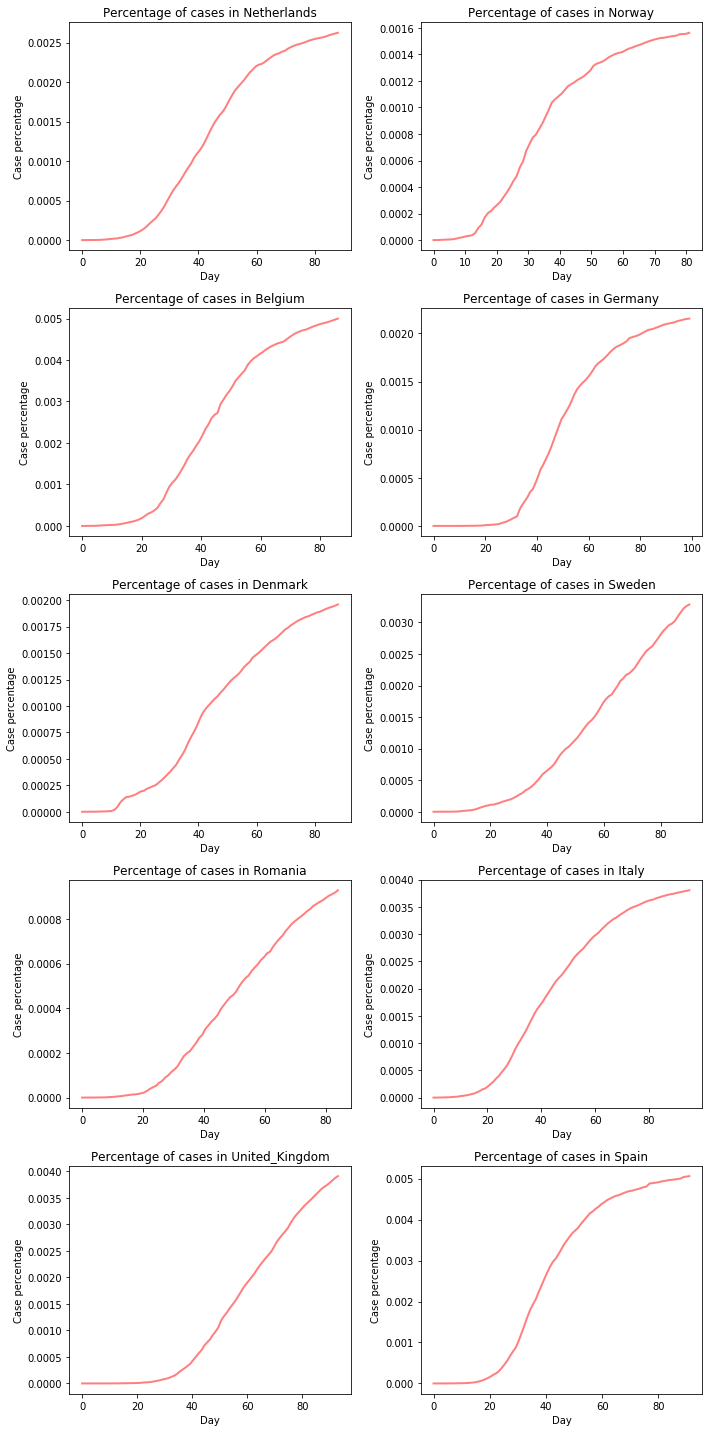

In [59]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for ax, country, percent in zip(axes.ravel(), dataframes, percentages):
    
    ax.plot(np.linspace(0, len(percent), len(percent)), percent, 'r', alpha=0.5, lw=2)

    ax.set_title('Percentage of cases in '+country.loc[0,['country']].values[0])
    ax.set_xlabel('Day')
    ax.set_ylabel('Case percentage')
#     ax.legend(['True positive tests', 'Expected positive tests'])
#     ax.set_xticklabels(country[['date']].values, rotation=90)

fig.tight_layout()

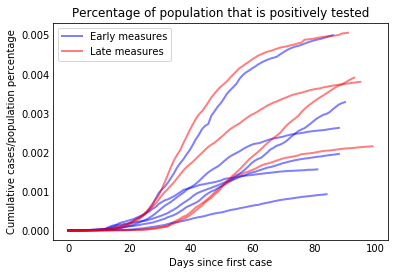

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111)

colors = ["r", "b", "g", "y", "c", "m", "orange", "springgreen", "darkviolet", "lawngreen"]
countries = ['Netherlands', 'Norway', 'Belgium', 'Germany', 'Denmark', 'Sweden', 'Romania', 'Italy', 'United_Kingdom', 'Spain']
ldc = [ 'Italy', 'Spain', 'United_Kingdom', 'Germany']

sdc = [c for c in countries if c not in ldc]

for p, col, count, country in zip(percentages, colors, countries, dataframes): 
    x = np.linspace(0, len(p), len(p))
#     ax.plot(x, p, col, alpha=0.5, lw=2, label=count)
    col = 'red' if count in ldc else 'blue'
    label = 'Late measures' if count in ldc else 'Early measures'

    ax.plot(x, p, col, alpha=0.5, lw=2, label =label)

ax.set_xlabel('Days since first case')
ax.set_ylabel('Cumulative cases/population percentage')
ax.set_title('Percentage of population that is positively tested')
# ax.legend('Lockdown', 'Social distancing')
handles, labels = plt.gca().get_legend_handles_labels()
# handles, labels = handles[2:4], labels[5:7]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(),by_label.keys())
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
# ax.grid(b=True, which='major', c='w', lw=2, ls='-')
# legend = ax.legend()
# legend.get_frame().set_alpha(0.5)
# for spine in ('top', 'right', 'bottom', 'left'):
#     ax.spines[spine].set_visible(True)
plt.rcParams["axes.grid"] = False
plt.show()

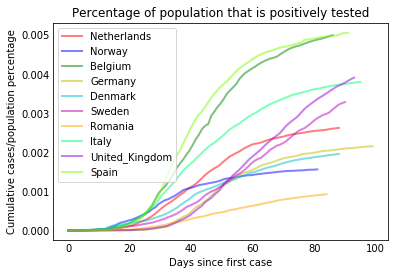

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111)

colors = ["r", "b", "g", "y", "c", "m", "orange", "springgreen", "darkviolet", "lawngreen"]
countries = ['Netherlands', 'Norway', 'Belgium', 'Germany', 'Denmark', 'Sweden', 'Romania', 'Italy', 'United_Kingdom', 'Spain']
ldc = [ 'Italy', 'Spain', 'United_Kingdom', 'Germany']

sdc = [c for c in countries if c not in ldc]

for p, col, count, country in zip(percentages, colors, countries, dataframes): 
    x = np.linspace(0, len(p), len(p))
#     ax.plot(x, p, col, alpha=0.5, lw=2, label=count)
#     col = 'red' if count in ldc else 'blue'
#     label = 'Late measures' if count in ldc else 'Early measures'

    ax.plot(x, p, col, alpha=0.5, lw=2, label =country['country'].unique()[0])

ax.set_xlabel('Days since first case')
ax.set_ylabel('Cumulative cases/population percentage')
ax.set_title('Percentage of population that is positively tested')
# ax.legend('Lockdown', 'Social distancing')
handles, labels = plt.gca().get_legend_handles_labels()
# handles, labels = handles[2:4], labels[5:7]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(),by_label.keys())
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
# ax.grid(b=True, which='major', c='w', lw=2, ls='-')
# legend = ax.legend()
# legend.get_frame().set_alpha(0.5)
# for spine in ('top', 'right', 'bottom', 'left'):
#     ax.spines[spine].set_visible(True)
plt.rcParams["axes.grid"] = False
plt.show()

### Seir Model

https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/, 
https://arxiv.org/pdf/2005.08882.pdf, https://en.wikipedia.org/wiki/Generalised_logistic_function

#### General model

In [36]:
days = 500
# days = np.round(len(data['cases'])/10)
increments = days*24*4
t = np.linspace(0, days, int(increments))
sigma = (1 + (0.25-1)/(1 + np.exp(-(1/5*(t-(30))))))
def sigmafunc(t):
    return (1 + (0.25-1)/(1 + np.exp(-(1/5*(t-(30))))))
beta = 0.4
eta = 1/5.1
ph = 0.1
ptd = 0.014
pud = 0.014
gamma1 = 1/4.8
gamma2 = 1/15
gammau = 1/10
theta = 0.014
thetau = 0.014
# N = np.unique(dataframes[0]['pop'].values)[0]
N = 1002
# I0 = dataframes[0]['cases'].values[0]
I0 = 1
Iu0 = 1
R0 = D0 = 0
E0 = 0
P0 = 0
Ru0 = 0
Du0= 0
S0 = N - I0 - P0 - R0 - E0 - D0 - Iu0 - Ru0 - Du0
y0 = S0, E0, I0, P0, R0, D0, Iu0, Ru0, Du0

No handles with labels found to put in legend.


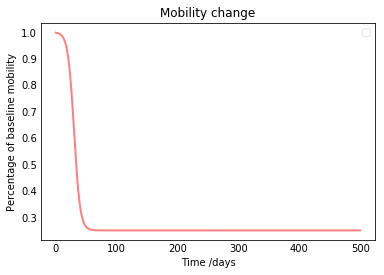

In [37]:
x = t
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
sigma = (1 + (0.25-1)/(1 + np.exp(-(1/5*(t-(30))))))
ax.plot(x, sigma, 'r', alpha=0.5, lw=2)

ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of baseline mobility')
ax.set_title('Mobility change')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
# ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
# for spine in ('top', 'right', 'bottom', 'left'):
#     ax.spines[spine].set_visible(False)
plt.show()

In [38]:
def deriv(y, t, N, sigma, beta, eta, theta, ph, gamma1, gamma2, ptd, pud, gammau, thetau, adjust=False):
    S, E, I, P, R, D, Iu, Ru, Du = y
    
    if adjust: 
        dSdt = (-(sigmafunc(t)*beta)*S*((I +Iu)/N))
        dEdt = (sigmafunc(t)*beta)*S*((I +Iu)/N) - eta*E  

    else:
        dSdt = (-(beta)*S*((I +Iu)/N))
        dEdt = (beta)*S*((I +Iu)/N) - eta*E   
    
    dIdt = (1-ph)*eta*E - gamma1 *I
    dPdt = gamma1*I -(1-ptd)*gamma2*P-ptd*theta*P
    dRdt = (1-ptd)*gamma2*P
    dDdt = ptd*theta*P
    dIudt = ph*eta*E-(1-pud)*gammau*Iu-pud*thetau*Iu
    dRudt = (1-pud)*gammau*Iu
    dDudt = pud*thetau*Iu
    return dSdt, dEdt, dIdt, dPdt, dRdt, dDdt, dIudt, dRudt, dDdt

Using the Euler method for derivatives

In [39]:
def euler(f,y0,a,b,h, S, E, I, P, R, D, Iu, Ru, Du, adjust=False):

    t1,y = a,y0
    while t1 <= b:
        t1 += h
        y += h * np.asarray(f(y, t1, N, sigma, beta, eta, theta, ph, gamma1, gamma2, ptd, pud, gammau, thetau, adjust))

        S.append(y[0])
        E.append(y[1])
        I.append(y[2])
        P.append(y[3])
        R.append(y[4])
        D.append(y[5])
        Iu.append(y[6])
        Ru.append(y[7])
        Du.append(y[8])
    return S, E, I, P, R, D, Iu, Ru, Du

No measures implemented

In [40]:
y = y0
S, E, I, P, R, D, Iu, Ru, Du = [S0], [E0], [I0], [P0], [R0], [D0], [Iu0], [Ru0], [Du0]
S, E, I, P, R, D, Iu, Ru, Du = euler(deriv,y,0,days,0.01, S, E, I, P, R, D, Iu, Ru, Du)

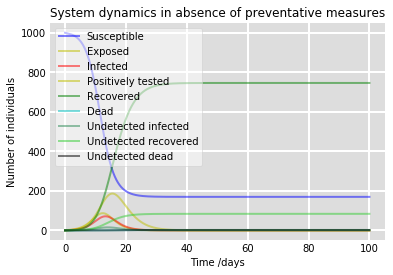

In [41]:
x = np.linspace(0, len(S), len(S))/days
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(x, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(x, E, 'y', alpha=0.5, lw=2, label='Exposed')
ax.plot(x, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(x, P, 'y', alpha=0.5, lw=2, label='Positively tested')
ax.plot(x, R, 'g', alpha=0.5, lw=2, label='Recovered')
ax.plot(x, D, 'c', alpha=0.5, lw=2, label='Dead')
ax.plot(x, Iu, 'seagreen', alpha=0.5, lw=2, label='Undetected infected')
ax.plot(x, Ru, 'limegreen', alpha=0.5, lw=2, label='Undetected recovered')
ax.plot(x, Du, 'k', alpha=0.5, lw=2, label='Undetected dead')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number of individuals')
ax.set_title('System dynamics in absence of preventative measures')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

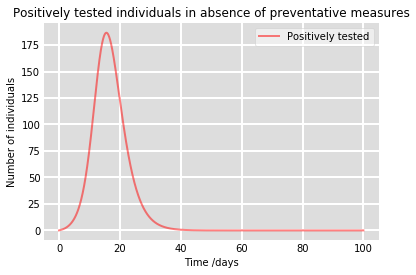

In [42]:
x = np.linspace(0, len(S), len(S))/days
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

ax.plot(x, P, 'r', alpha=0.5, lw=2, label='Positively tested')


ax.set_xlabel('Time /days')
ax.set_ylabel('Number of individuals')
ax.set_title('Positively tested individuals in absence of preventative measures')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

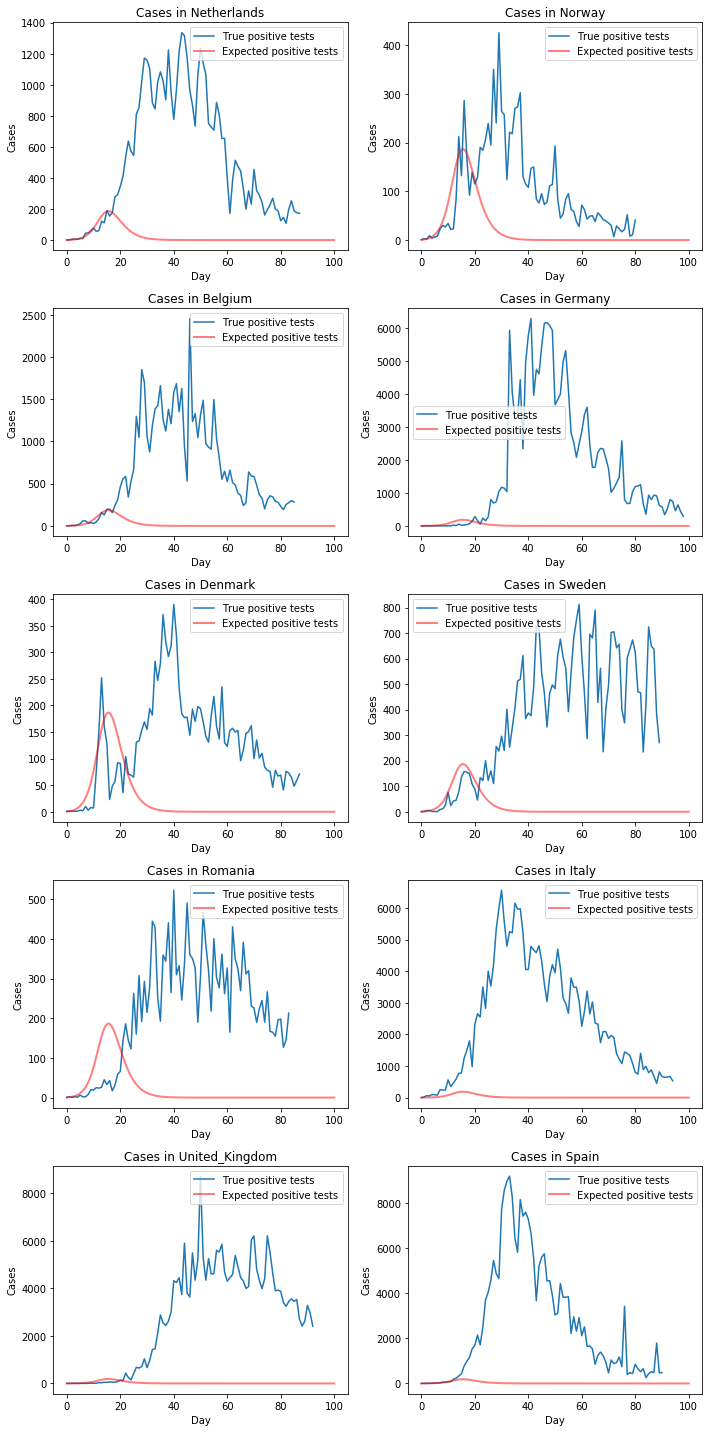

In [43]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for ax, country in zip(axes.ravel(), dataframes):
    
    ax.plot(country[['cases']].values)
    ax.plot(np.linspace(0, len(I), len(I))/days, P, 'r', alpha=0.5, lw=2)

    ax.set_title('Cases in '+country.loc[0,['country']].values[0])
    ax.set_xlabel('Day')
    ax.set_ylabel('Cases')
    ax.legend(['True positive tests', 'Expected positive tests'])
#     ax.set_xticklabels(country[['date']].values, rotation=90)

fig.tight_layout()

Using adjusted mobility

In [44]:
y = y0
S2, E2, I2, P2, R2, D2, Iu2, Ru2, Du2 = [S0], [E0], [I0], [P0], [R0], [D0], [Iu0], [Ru0], [Du0]
S2, E2, I2, P2, R2, D2, Iu2, Ru2, Du2 = euler(deriv,y,0,days,0.01, S2, E2, I2, P2, R2, D2, Iu2, Ru2, Du2, adjust = True)

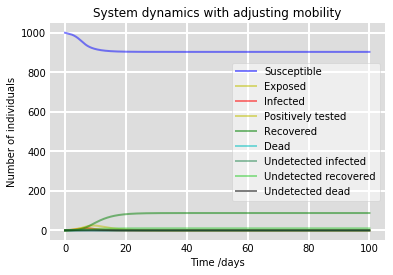

In [45]:
x = np.linspace(0, len(S), len(S))/days
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(x, S2, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(x, E2, 'y', alpha=0.5, lw=2, label='Exposed')
ax.plot(x, I2, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(x, P2, 'y', alpha=0.5, lw=2, label='Positively tested')
ax.plot(x, R2, 'g', alpha=0.5, lw=2, label='Recovered')
ax.plot(x, D2, 'c', alpha=0.5, lw=2, label='Dead')
ax.plot(x, Iu2, 'seagreen', alpha=0.5, lw=2, label='Undetected infected')
ax.plot(x, Ru2, 'limegreen', alpha=0.5, lw=2, label='Undetected recovered')
ax.plot(x, Du2, 'k', alpha=0.5, lw=2, label='Undetected dead')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number of individuals')
ax.set_title('System dynamics with adjusting mobility')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

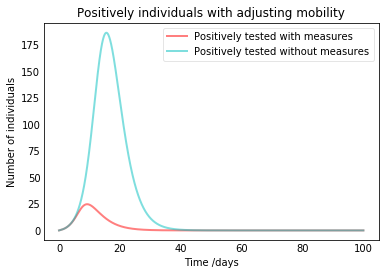

In [46]:
x = np.linspace(0, len(S), len(S))/days
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(x, P2, 'r', alpha=0.5, lw=2, label='Positively tested with measures')
ax.plot(x, P, 'c', alpha=0.5, lw=2, label='Positively tested without measures')


ax.set_xlabel('Time /days')
ax.set_ylabel('Number of individuals')
ax.set_title('Positively individuals with adjusting mobility')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
# ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
# for spine in ('top', 'right', 'bottom', 'left'):
#     ax.spines[spine].set_visible(False)
plt.show()

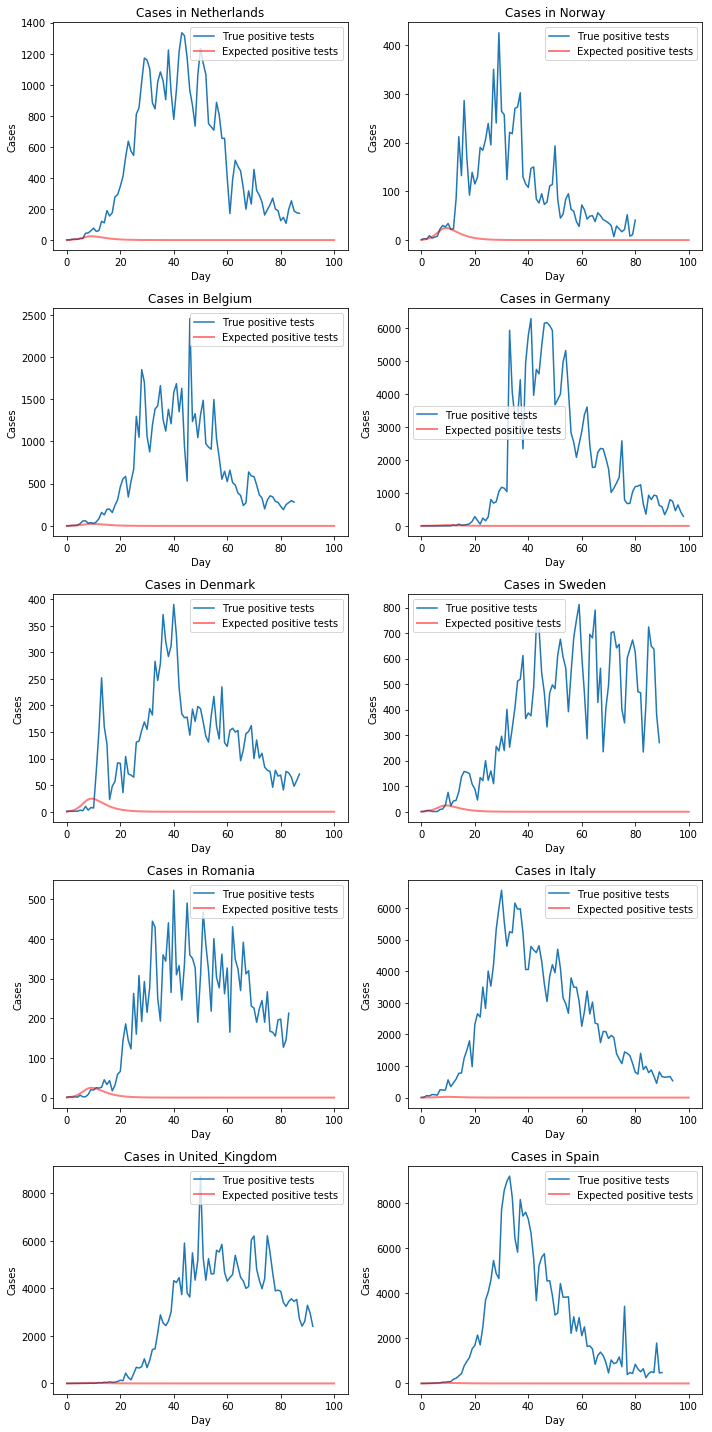

In [47]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for ax, country in zip(axes.ravel(), dataframes):
    
    ax.plot(country[['cases']].values)
    ax.plot(np.linspace(0, len(P2), len(P2))/days, P2, 'r', alpha=0.5, lw=2)

    ax.set_title('Cases in '+country.loc[0,['country']].values[0])
    ax.set_xlabel('Day')
    ax.set_ylabel('Cases')
    ax.legend(['True positive tests', 'Expected positive tests'])
#     ax.set_xticklabels(country[['date']].values, rotation=90)

fig.tight_layout()

#### SEIR per country

Mobility data retrieved from https://www.google.com/covid19/mobility/index.html?hl=en on 6-6-2020

In [48]:
countrylist =  [country['country'].unique()[0] for country in dataframes]
countrylist = list(map(lambda x: x if x != 'United_Kingdom' else 'United Kingdom', countrylist))
mobility = pd.read_csv('data/Global_Mobility_Report.csv')
mobility = mobility.loc[mobility['country_region'].isin(countrylist)]
mobility['date'] = pd.to_datetime(mobility['date'], format='%Y-%m-%d')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


To model the adjusted mobility, the sigmoid function will now use the mobility of 25-5-2020 as the lower asymptote (instead of using 25% of the normal mobility).

In [49]:
mobility_change = [np.mean(mobility.loc[(mobility['country_region']==country)&(mobility['sub_region_1'].isnull()) & (mobility['sub_region_2'].isnull()) & (mobility['date']=='2020-05-25'), ['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline']].values) for country in countrylist]
mobility_change

[-25.75, -10.0, -30.0, -19.0, -14.25, -12.0, -28.0, -32.0, -56.0, -37.25]

In [50]:
start_measure_dates = ['2020-03-23', '2020-03-12', '2020-03-12', '2020-03-22', '2020-03-18', '2020-03-25', '2020-03-24', '2020-03-09', '2020-03-26', '2020-03-14']

In [51]:
def SEIR_country(mobility_ch, country, date):
    days = len(country['cases'])
    increments = days*24*4
    t = np.linspace(0, days, int(increments))
    start_meas = country.loc[country['date'] == date].index[0]
    sigma = (1 + ((1-(np.abs(mobility_ch)/100))-1)/(1 + np.exp(-(1*(t-(start_meas+5))))))
    
    def sigmafunc(t, *args):
        return (1 + ((1-(np.abs(mobility_ch)/100))-1)/(1 + np.exp(-(1*(t-(start_meas+5))))))
    beta = 0.4
    eta = 1/5.1
    ph = 0.1
    ptd = 0.014
    pud = 0.014
    gamma1 = 1/4.8
    gamma2 = 1/15
    gammau = 1/10
    theta = 0.014
    thetau = 0.014
#     N = country['pop'].values[0]
    N = 3000 + country.loc[0].cases * 2 + country.loc[4].cases
#     N = country.max().cases
#     N = 1000
    P0 = country.loc[0].cases
    Iu0 = 0
    R0 = D0 = 0
    E0 = country.loc[4].cases
    I0 = country.loc[0].cases
    Ru0 = 0
    Du0= 0
    S0 = N - I0 - P0 - R0 - E0 - D0 - Iu0 - Ru0 - Du0
    y0 = S0, E0, I0, P0, R0, D0, Iu0, Ru0, Du0
    
    y = y0
    S, E, I, P, R, D, Iu, Ru, Du = [S0], [E0], [I0], [P0], [R0], [D0], [Iu0], [Ru0], [Du0]
    S, E, I, P, R, D, Iu, Ru, Du = euler(deriv,y,0,days,0.01, S, E, I, P, R, D, Iu, Ru, Du, adjust = True)
    return S, E, I, P, R, D, Iu, Ru, Du

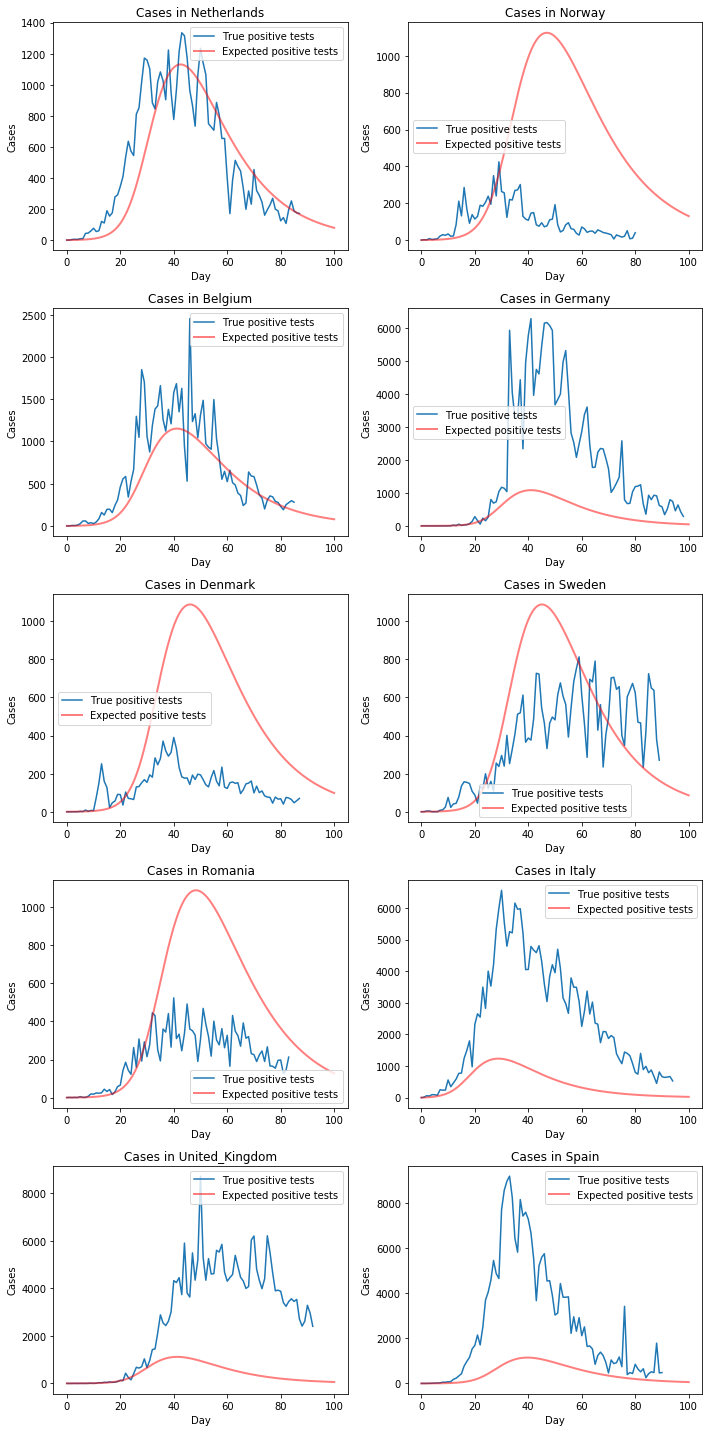

In [52]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

allPosTest=[]
for ax, country, mobility_ch, date in zip(axes.ravel(), dataframes, mobility_change, start_measure_dates):
    S, E, I, P, R, D, Iu, Ru, Du = SEIR_country(mobility_ch, country, date)
    allPosTest.append(P)
    
    ax.plot(country[['cases']].values)
    ax.plot(np.linspace(0, len(I), len(I))/len(country['cases']), P, 'r', alpha=0.5, lw=2)

    ax.set_title('Cases in '+country.loc[0,['country']].values[0])
    ax.set_xlabel('Day')
    ax.set_ylabel('Cases')
    ax.legend(['True positive tests', 'Expected positive tests'])
#     ax.set_xticklabels(country[['date']].values, rotation=90)

fig.tight_layout()


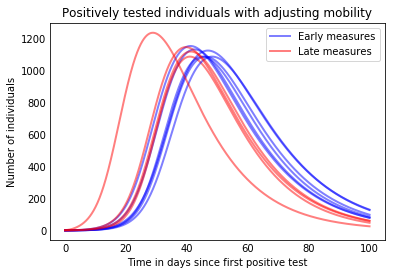

In [57]:
x = np.linspace(0, len(S), len(S))/len(country['cases'])
fig = plt.figure()
ax = fig.add_subplot(111)

colors = ["r", "b", "g", "y", "c", "m", "orange", "springgreen", "darkviolet", "lawngreen"]
countries = ['Netherlands', 'Norway', 'Belgium', 'Germany', 'Denmark', 'Sweden', 'Romania', 'Italy', 'United_Kingdom', 'Spain']
ldc = [ 'Italy', 'Spain', 'United_Kingdom', 'Germany']

sdc = [c for c in countries if c not in ldc]

for p, col, count, country in zip(allPosTest, colors, countries, dataframes): 
    x = np.linspace(0, len(p), len(p))/len(country['cases'])
#     ax.plot(x, p, col, alpha=0.5, lw=2, label=count)
    col = 'red' if count in ldc else 'blue'
    label = 'Late measures' if count in ldc else 'Early measures'
    ax.plot(x, p, col, alpha=0.5, lw=2, label = label)

ax.set_xlabel('Time in days since first positive test')
ax.set_ylabel('Number of individuals')
ax.set_title('Positively tested individuals with adjusting mobility')
# ax.legend('Lockdown', 'Social distancing')
handles, labels = plt.gca().get_legend_handles_labels()
# handles, labels = handles[2:4], labels[5:7]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(),by_label.keys())
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
# ax.grid(b=True, which='major', c='w', lw=2, ls='-')
# legend = ax.legend()
legend.get_frame().set_alpha(0.5)
# for spine in ('top', 'right', 'bottom', 'left'):
#     ax.spines[spine].set_visible(True)
plt.rcParams["axes.grid"] = False
plt.show()

Infected curve for the last country in the dataframes list (Spain)

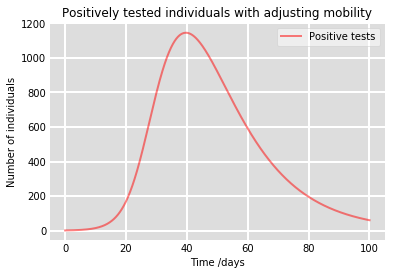

In [54]:
x = np.linspace(0, len(S), len(S))/len(country['cases'])
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(x, P, 'r', alpha=0.5, lw=2, label='Positive tests')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number of individuals')
ax.set_title('Positively tested individuals with adjusting mobility')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

Attempting to adjust mobility on a daily basis according to the data (instead of using a sigmoid function based on the mobility information of the last day in the timeseries). The 'country' variable represents Spain.

No handles with labels found to put in legend.


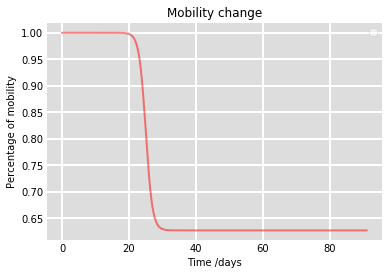

In [55]:
x = np.linspace(0, len(S), len(S))/len(country['cases'])
days = len(country['cases'])
increments = days*24*4
t = np.linspace(0, days, int(increments))
x = t
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
sigma = (1 + ((1-(np.abs(mobility_ch)/100))-1)/(1 + np.exp(-(1*(t-(country.loc[country['date'] == date].index[0]+5))))))
ax.plot(x, sigma, 'r', alpha=0.5, lw=2)

ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of mobility')
ax.set_title('Mobility change')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()


In [76]:
mobility.loc[(mobility['country_region'] == 'Belgium')&(mobility['sub_region_1'].isnull())&(mobility['sub_region_2'].isnull()&(mobility['date'].between(dataframes[2].min().date, dataframes[2].max().date)))]

,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
7681,BE,Belgium,NaN,NaN,2020-02-15,3.0,2.0,29.0,9.0,1.0,-1.0
7682,BE,Belgium,NaN,NaN,2020-02-16,-7.0,-3.0,-30.0,-3.0,-3.0,1.0
7683,BE,Belgium,NaN,NaN,2020-02-17,1.0,2.0,8.0,4.0,4.0,0.0
7684,BE,Belgium,NaN,NaN,2020-02-18,3.0,3.0,18.0,6.0,4.0,0.0
7685,BE,Belgium,NaN,NaN,2020-02-19,3.0,1.0,13.0,5.0,4.0,0.0
7686,BE,Belgium,NaN,NaN,2020-02-20,-2.0,-1.0,4.0,3.0,3.0,0.0
7687,BE,Belgium,NaN,NaN,2020-02-21,0.0,3.0,15.0,7.0,2.0,0.0
7688,BE,Belgium,NaN,NaN,2020-02-22,-4.0,0.0,0.0,2.0,-2.0,0.0
7689,BE,Belgium,NaN,NaN,2020-02-23,-7.0,-7.0,-27.0,-2.0,-4.0,0.0
7690,BE,Belgium,NaN,NaN,2020-02-24,7.0,0.0,7.0,-11.0,-24.0,4.0


In [77]:
dataframes[2].min().date

Timestamp('2020-02-04 00:00:00')